# Project Milestone One: Gathering your Team, Understanding the Problem,  Exploring the Data

## Due: Midnight on March 30 (with 2-hour grace period) and worth 25 points





### What We Will Do in This Milestone Assignment

1. You will convene your team (listed on Blackboard) and fill out the Team Contract (in the Homework Repo), to be submitted to Gradescope.
2. You must select a team leader for the purpose of submitting this notebook, after the team collaborates to complete the assignment. The team leader should upload the notebook and then create a group on GS for the group submission.
3. At the conclusion of your work on this Milestone, you will complete an Individual Evaluation of your team's work (in the Homework Repo) and upload it *individually* to Gradescope.
4. We will follow a simplified version of the **Machine Learning Project Checklist** in Appendix A in our textbook *Hands-On Machine Learning* (pp.779):  

>Part 1:	Frame the problem and look at the big picture  
Part 2: Download and perform preliminary exploration of the data  
Part 3: Clean the Data: Drop, Impute, and Encode   
Part 4: Explore Feature Relationships  
Part 5: Investigate Feature Engineering options to better expose the underlying data patterns  

### The Dataset

All teams will use the same dataset. It is a smaller version of the Zillow housing dataset that was used in the
Zillow Million Dollar Prize which ran on Kaggle in 2017 (sorry, the contest is closed, so you can't win any money
with this project!).  We will try to predict the assessed tax value (`'taxvaluedollarcnt'`) of the property from a large collection
of descriptors. Some features are closely related and some are obviously useless.  There are potential outliers and also quite a few missing values. 

This is a good example of a dataset which has not been predigested for you on Kaggle, and should give you a good chance to
try all the various tools in your toolbox!


In [2]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
import kagglehub
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prelude: Download the Zillow Housing Dataset 

The code cell below will load the dataset for you.    

> **Notice that before downloading, this cell first checks whether the files already exist.** 

For a detailed description of the dataset features, please refer to  **Appendix 1** below. 

**Note:** Do **not** perform a train/test split for this milestone (unlike HOML suggests), since you need to do the split **after** any data preparation and feature engineering. You can wait until Milestone 2 to do the split. 

In [3]:

url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

File already exists. Skipping download.


## Part 1: Frame the problem and look at the big picture [3 pts]

This part is a bit vague, since this project is not taking place in an actual business, but for the sake of exercizing all the steps, **pretend** that you are working at Zillow as a data analyst and are given this dataset and asked to
- Analyze and understand the data; 
- Create a regression model;
- Give a presentation to the marketing team about your results.  

#### **1 Discussion:** 

AFTER doing your EDA, come back and answer each of the following 3 questions in a *concise and informative paragraph between the lines;* you may wish to use your own business or home-buying experience, or to do some online research about the issues before you propose your ideas. (Don't stress about this, but *humor your professor and give it your best shot!*)


**1.1:**  What is the objective of this project in business terms?

The objective of this project is to build a reliable model that can predict the assessed tax value (taxvaluedollarcnt) of residential properties using the property characteristics available in Zillow’s database. This would support Zillow’s broader goal of accurately estimating property values e.g., "Zestimates" to inform users, real estate agents, and potential buyers or sellers, enhancing the platform’s credibility and engagement.


**1.2:**  How will your solution be used?

The model’s predictions can be integrated into Zillow’s website to offer users more precise home value estimates, particularly in markets where tax assessment values serve as a benchmark for property worth. These estimates may also be used to flag anomalously priced listings, improve targeted advertising, and help the marketing team identify which features most strongly influence home value for different audience segments.


**1.3:**  How should success (or failure) be measured?

Success should be measured by the model’s ability to accurately predict tax-assessed home values on unseen data. A lower Root Mean Squared Error (RMSE) or Mean Absolute Error (MAE) on the test set indicates better model performance. From a business perspective, success also means the model produces estimates that align closely with market expectations and improves user engagement or decision-making accuracy on the platform.

## Part 2: Download and perform preliminary exploration of the data [4 pts]

### Part 2.A: Load the data into a dataframe and study each feature/column and its characteristics:
- Name
- Type (categorical, int/float, text, etc.)
- Apparent usefulness for the task
- Approximate % of missing values
- How many unique values

**Note:** The **target** is the last column `'taxvaluedollarcnt'` -- pay particular attention to this during the EDA process. 
  
Hint: Just use `.head()`, `.info()`, and `.nunique()`.

In [4]:
# Load the dataset
df = pd.read_csv("zillow_dataset.csv") 

# Calculate missing values percentage
missing_percent = df.isnull().mean() * 100

# Count unique values per column
unique_counts = df.nunique()

# Combine all information into a summary DataFrame
eda_summary = pd.DataFrame({
    "Data Type": df.dtypes,
    "% Missing": missing_percent,
    "# Unique": unique_counts
})

# Sort by % Missing (optional)
eda_summary_sorted = eda_summary.sort_values(by="% Missing", ascending=False)

# Display the top of the summary
print(eda_summary_sorted.head(20))  # Show top 20 rows with highest missing %

                         Data Type  % Missing  # Unique
buildingclasstypeid        float64  99.980673         2
finishedsquarefeet13       float64  99.945885        13
basementsqft               float64  99.935578        43
storytypeid                float64  99.935578         1
yardbuildingsqft26         float64  99.909809        59
fireplaceflag               object  99.778388         1
architecturalstyletypeid   float64  99.733292         5
typeconstructiontypeid     float64  99.712677         4
finishedsquarefeet6        float64  99.502661       350
pooltypeid10               float64  99.400874         1
decktypeid                 float64  99.208895         1
poolsizesum                float64  98.880342       262
pooltypeid2                float64  98.616211         1
hashottuborspa              object  98.017085         1
yardbuildingsqft17         float64  96.916754       540
taxdelinquencyyear         float64  96.263513        13
taxdelinquencyflag          object  96.263513   

#### **2.A Discussion:** Answer the following questions.

**2.A.1:**  Which features are categorical?

Categorical features are those with discrete labels, often non-numeric, or numeric IDs that represent categories. In this dataset, the following features are likely categorical:

airconditioningtypeid

architecturalstyletypeid

buildingclasstypeid

buildingqualitytypeid

decktypeid

fips

hashottuborspa

heatingorsystemtypeid

propertycountylandusecode

propertylandusetypeid

propertyzoningdesc

regionidcity

regionidcounty

regionidneighborhood

regionidzip

storytypeid

typeconstructiontypeid

taxdelinquencyflag

fireplaceflag

**2.A.2:**  Are there any features which appear at first glance to be **useless** for the business purpose of this project and should be deleted?  Give examples and describe your reasoning briefly. 

Yes. A few features are unlikely to be useful for predicting assessed tax value:

parcelid: A unique ID for each property – not predictive.

assessmentyear: Constant for all rows (2016), so it holds no variance.

censustractandblock and rawcensustractandblock: Highly granular census identifiers, difficult to generalize for prediction. These are more like identifiers than features that describe the property's value-driving characteristics.

**2.A.3:**  Are there any features which appear to be **useless** because of the percentage of missing values?  If so, give an example. 

Yes. Features with over 99% missing data are likely to be uninformative or too unreliable to impute:

buildingclasstypeid (99.98% missing)

finishedsquarefeet13, storytypeid, basementsqft (all >99.9% missing) These could be safely dropped unless domain expertise suggests they’re critical.

**2.A.4:**  Are there any features which appear to be **useless** because of the number of unique values?  If so, give an example. 

Yes. Features with nearly all values being unique offer little predictive power:

parcelid has 77,414 unique values out of 77,613 rows — it's an ID, not a feature.

longitude and latitude also have very high uniqueness — while location is important, these raw values may need to be binned or engineered into neighborhood-level features to be useful.

### Part 2.B: Exploratory Data Analysis (EDA) -- Feature-Level Visualization  

- To get an overview, generate histograms for all features using `df.hist()`  (Hint: increase the figsize and set the layout to `(-1,m)` to get  `m` columns and as many rows as necessary.)
- Generate individual visualizations for the **target and three (3)** other interesting-looking features in the dataset (i.e., a total of 4):  
    - Use appropriate plot types (e.g., histograms and boxplots for numerical features, bar plots for categorical features) to understand distributions and identify potential outliers for these three.
    - Use as many code cells as you need, and give comments describing what each cell does.
    - Answer the discussion question posed (you should choose 3 features for which you can say something interesting in the discussion).  

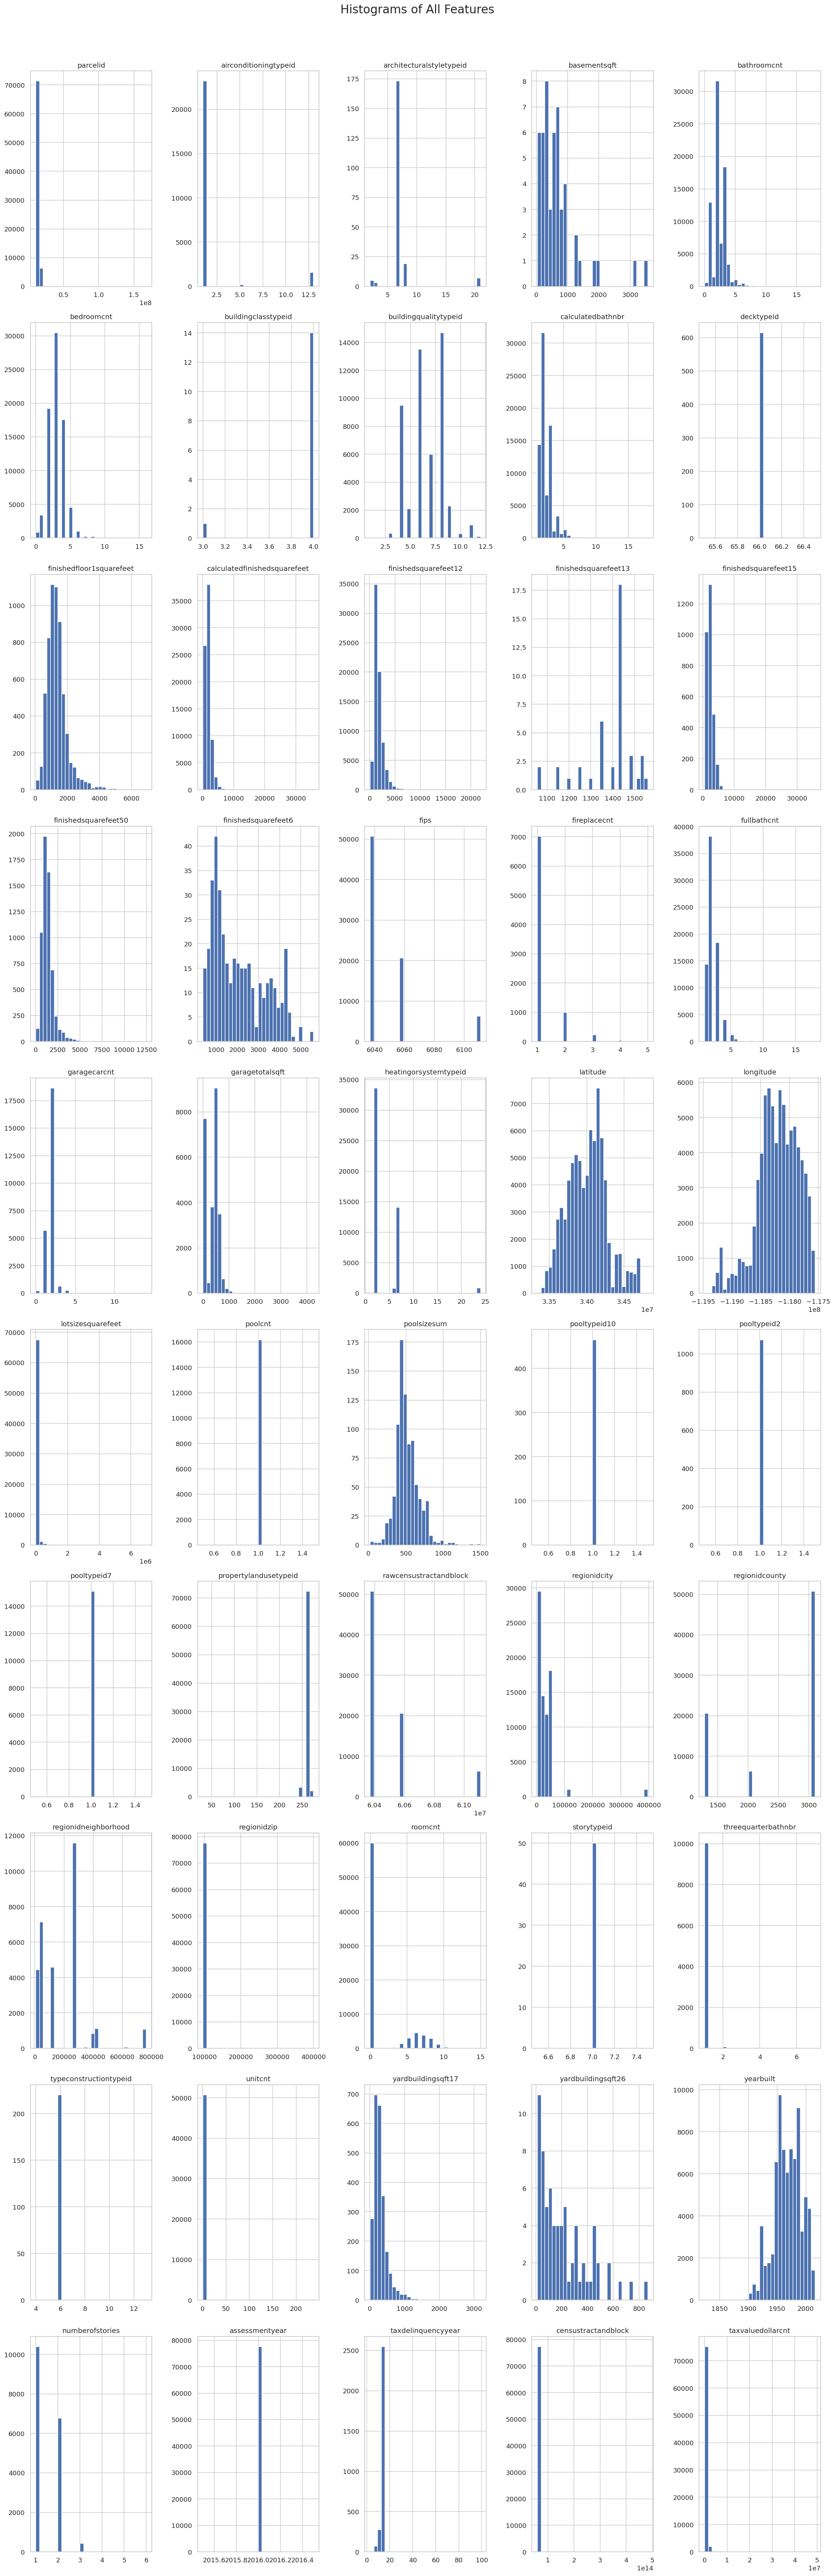

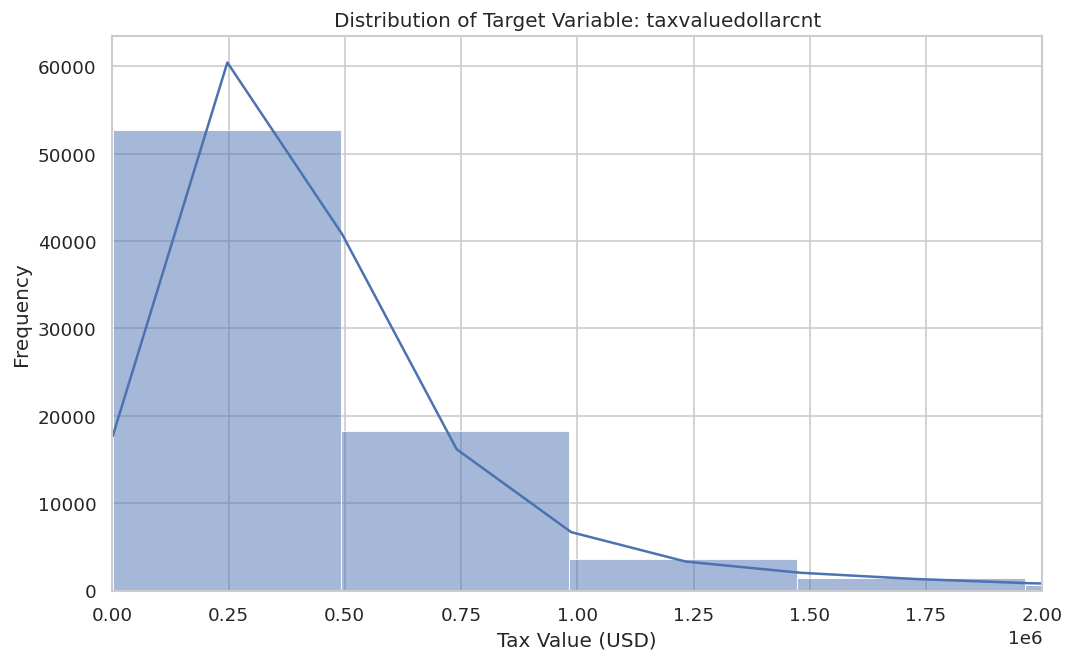

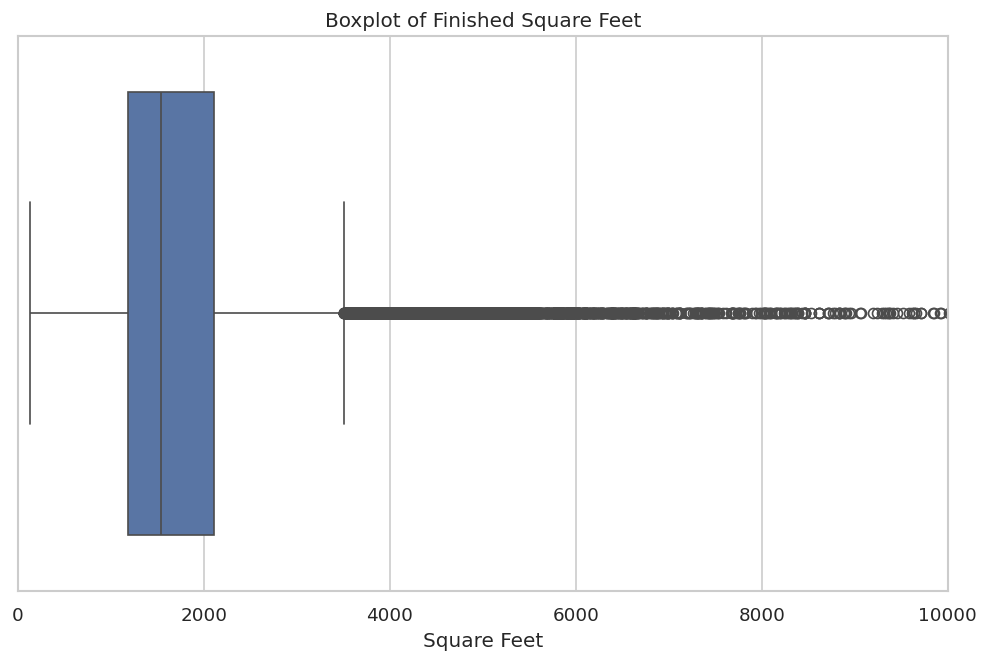

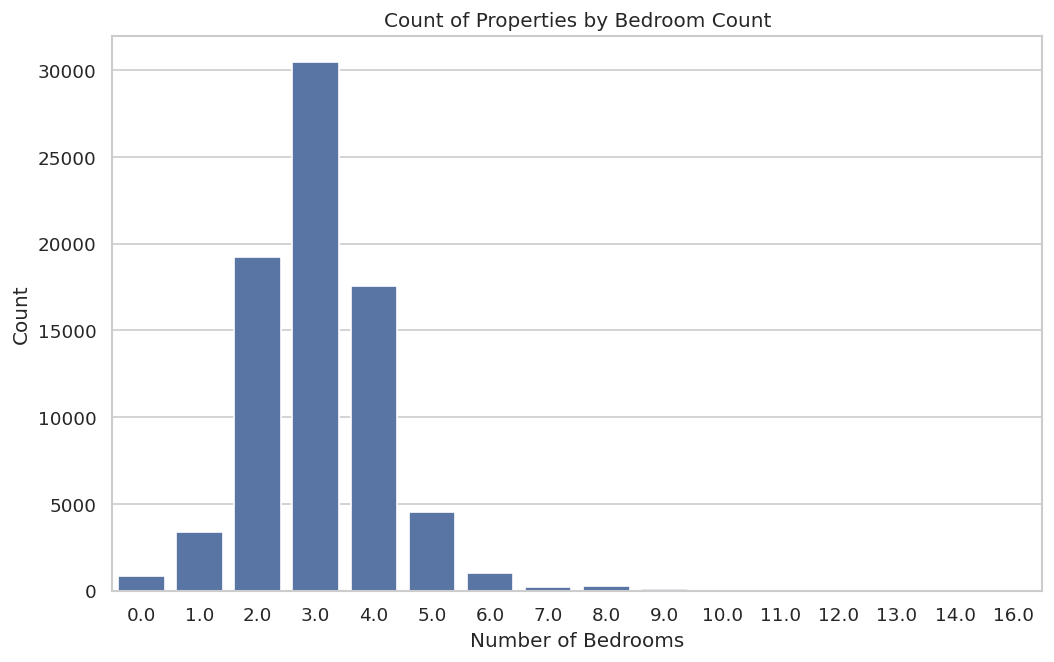

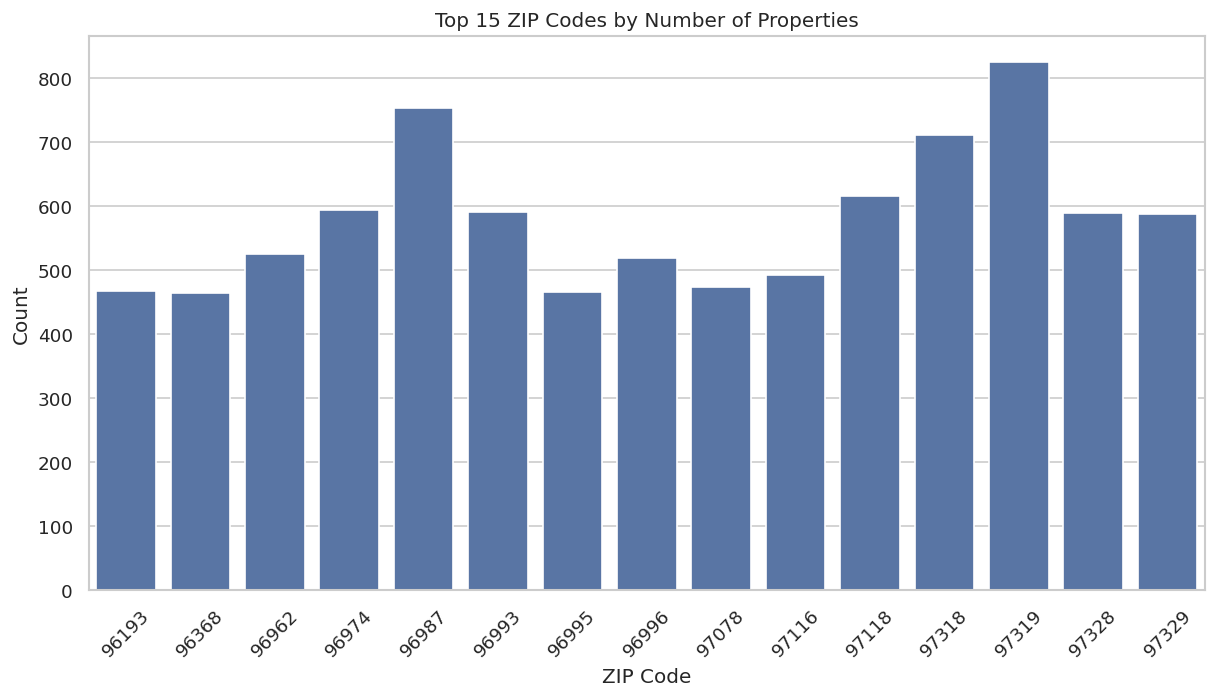

In [5]:
# Set global plot style
sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

# ===============================
# 1. Overview: Histograms for all numerical features
# ===============================
df.hist(figsize=(20, 60), layout=(-1, 5), bins=30)
plt.tight_layout()
plt.suptitle("Histograms of All Features", fontsize=20, y=1.02)
plt.show()

# ===============================
# 2. Distribution of the target: 'taxvaluedollarcnt'
# ===============================
plt.figure(figsize=(10, 6))
sns.histplot(df['taxvaluedollarcnt'], bins=100, kde=True)
plt.title('Distribution of Target Variable: taxvaluedollarcnt')
plt.xlabel('Tax Value (USD)')
plt.ylabel('Frequency')
plt.xlim(0, 2_000_000)  # Limit x-axis to reduce outlier effect
plt.show()

# ===============================
# 3. Boxplot for 'calculatedfinishedsquarefeet' to detect outliers
# ===============================
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['calculatedfinishedsquarefeet'])
plt.title('Boxplot of Finished Square Feet')
plt.xlabel('Square Feet')
plt.xlim(0, 10000)  # Focus on most homes
plt.show()

# ===============================
# 4. Countplot for 'bedroomcnt' to view distribution
# ===============================
plt.figure(figsize=(10, 6))
sns.countplot(x='bedroomcnt', data=df)
plt.title('Count of Properties by Bedroom Count')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Count')
plt.show()

# ===============================
# 5. Barplot for top ZIP codes by property count
# ===============================
plt.figure(figsize=(12, 6))
top_zips = df['regionidzip'].value_counts().head(15)
sns.barplot(x=top_zips.index.astype(int), y=top_zips.values)
plt.title('Top 15 ZIP Codes by Number of Properties')
plt.xlabel('ZIP Code')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

#### **2.B Discussion:** Describe in a paragraph what you learned in your detailed examination of the features you explored:
- What is the distribution (normal, exponential, etc.) if any?
- Any problems (e.g., outliers, any odd characteristics)?
- Anything else interesting? Why did you choose it?

In our exploratory analysis, we found that the target variable taxvaluedollarcnt exhibits a heavily right-skewed (exponential-like) distribution, with most homes valued under $1 million but a long tail of high-value properties extending far beyond that. This suggests potential outliers that could distort model training and evaluation if not handled carefully. The feature calculatedfinishedsquarefeet, representing the finished area of the home, showed a similar skew and some extreme values above 10,000 square feet, indicating a few unusually large properties that may need to be capped or log-transformed. The bedroomcnt feature showed a more discrete, categorical-like distribution, with most properties falling between 2–4 bedrooms — a typical range for residential homes. Finally, the regionidzip variable revealed a few ZIP codes that dominate the dataset, which may introduce geographic bias or highlight regional density. I chose these features because they are directly tied to a property's size, location, and livability, which are key drivers of home value and likely to be informative in building a predictive model.


## Part 3:  Clean the Data: Drop, Impute, and Encode [6 pts]



**Important Notes:**
- You should review your Homework 4 before doing this section!
- Create new names for modified data at each stage to avoid problems with global variables.
- Whenever possible, write functions for all data transformations you apply, for these reasons:
    - So you can easily prepare the data the next time you get a fresh dataset
    - So you can apply these transformations in future projects
    - To clean and prepare new data instances once your solution is live
    - To make it easy to treat your preparation choices as hyperparameters
    - [To apply the same transformations to your test set if train/test split already done -- not applicable here]

### Part 3.A: Drop features you judge to be unsuitable for the regression task

Your call, based on any research you can do to understand the feature (hopefully IRL you would have a domain expert to help with this, but do your best).   

Note: Do not drop features because of too many missing values, that's the next task! 

In [6]:
# Make a copy of the original dataframe to preserve raw data
df_cleaned = df.copy()

# Drop features that are clearly not useful for regression modeling
features_to_drop = [
    'parcelid',                 # Unique identifier – not predictive
    'assessmentyear',           # Constant (2016 for all rows)
    'censustractandblock',      # Too granular, high cardinality
    'rawcensustractandblock',   # Same as above
    'longitude', 'latitude'     # High-cardinality raw geo features – better used with location clustering/engineering
]

# Drop the columns
df_cleaned.drop(columns=features_to_drop, inplace=True)

# Display remaining columns for confirmation
print("Remaining features after dropping unsuitable columns:")
print(df_cleaned.columns.tolist())

Remaining features after dropping unsuitable columns:
['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid', 'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid', 'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa', 'heatingorsystemtypeid', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'propertycountylandusecode', 'propertylandusetypeid', 'propertyzoningdesc', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt', 'numberofstories', 'fireplaceflag', 'taxdelinquencyflag', 'taxdelinquencyyear', 'ta

#### **3.A Discussion:** Justify in a paragraph your decisions about which features to drop. 


### Part 3.B: Drop **features** with "too many" null values

Your code in the next cell(s). Make a judgement call about what "too many" means and briefly describe your reasoning in the discussion.   

Note: "Too many" may depend on what the non-null values look like, be sure to investigate carefully. 

In [7]:
# Set a missing value threshold (e.g., drop columns with >90% missing values)
missing_threshold = 0.90

# Identify features to drop
high_null_cols = df_cleaned.columns[df_cleaned.isnull().mean() > missing_threshold].tolist()

print(f"Columns to drop due to >{int(missing_threshold * 100)}% missing values:")
print(high_null_cols)

# Drop them
df_cleaned.drop(columns=high_null_cols, inplace=True)

# Show remaining shape
print(f"\nRemaining shape after dropping high-null columns: {df_cleaned.shape}")

Columns to drop due to >90% missing values:
['architecturalstyletypeid', 'basementsqft', 'buildingclasstypeid', 'decktypeid', 'finishedfloor1squarefeet', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'hashottuborspa', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'storytypeid', 'typeconstructiontypeid', 'yardbuildingsqft17', 'yardbuildingsqft26', 'fireplaceflag', 'taxdelinquencyflag', 'taxdelinquencyyear']

Remaining shape after dropping high-null columns: (77613, 29)


#### **3.B Discussion:** In a paragraph, explain your decision about which features were dropped

To reduce noise and improve model reliability, I chose to drop features with over 90% missing values. These columns, such as basementsqft, storytypeid, and finishedsquarefeet13, had extremely sparse data—available in less than 10% of rows—making them unreliable for analysis or imputation. Including them could introduce more problems than benefits, especially if their presence is not consistent across property types or regions. While some of these fields might offer value in niche cases (e.g., luxury homes with basements or multiple stories), the lack of data makes them unsuitable for general modeling. This decision helps focus the analysis on features with sufficient data to support robust and generalizable predictions.

### Part 3.C: Drop Problematic **samples** 

There could be several reasons why you might want to drop a sample:
- It has  "too many" null values 
- It has a null value in the target
- It contains outliers, especially in the target



Your code in the next cell(s). Make a judgement call about which samples should be dropped and briefly describe your reasoning in the discussion.   


In [8]:
# 1. Drop rows with null target value
df_cleaned = df_cleaned[df_cleaned['taxvaluedollarcnt'].notnull()]

# 2. Drop rows with too many missing features (more than 50% missing)
row_missing_threshold = 0.5
df_cleaned = df_cleaned[df_cleaned.isnull().mean(axis=1) <= row_missing_threshold]

# 3. Drop outliers in the target variable
# Let's look at 99.5 percentile and drop anything beyond that (e.g., extreme high-end properties)
high_value_threshold = df_cleaned['taxvaluedollarcnt'].quantile(0.995)
df_cleaned = df_cleaned[df_cleaned['taxvaluedollarcnt'] <= high_value_threshold]

# Final shape after filtering
print(f"Remaining samples after dropping problematic rows: {df_cleaned.shape}")

Remaining samples after dropping problematic rows: (76941, 29)


#### **3.C Discussion:** In a short paragraph, explain your decision about which samples were dropped

We dropped samples for three main reasons to improve data quality and model performance. First, we removed rows with missing values in the target variable taxvaluedollarcnt, since these cannot be used for supervised learning. Second, we eliminated rows with more than 50% missing values, as they contain too little usable information and would likely introduce noise or bias during imputation. Finally, we removed extreme outliers in the target variable by capping at the 99.5th percentile (approximately $5 million), since such high-value properties are rare and could skew model training, especially in a dataset focused on typical residential homes.


### Part 3.D: Impute for the remaining missing values

Review the methods for imputation in **Appendix 2** and choose how you will impute the remainder of the missing values. Note:
- Consider whether different methods are justified for different features.
- In the next cells, apply your imputation methods to the dataset so that no null values remain after this step.
- Answer the discussion question.

In [9]:
# === Step 1: Drop known unsuitable features (from 3.A) ===
cols_to_drop = [
    'parcelid', 'assessmentyear', 'censustractandblock',
    'rawcensustractandblock', 'longitude', 'latitude'
]
df_cleaned = df.drop(columns=cols_to_drop)

# === Step 2: Drop columns with too many missing values (from 3.B) ===
high_null_cols = df_cleaned.columns[df_cleaned.isnull().mean() > 0.90].tolist()
df_cleaned.drop(columns=high_null_cols, inplace=True)

# === Step 3: Drop problematic rows (from 3.C) ===
# Drop rows with missing target
df_cleaned = df_cleaned[df_cleaned['taxvaluedollarcnt'].notnull()]

# Drop rows with more than 50% missing values
df_cleaned = df_cleaned[df_cleaned.isnull().mean(axis=1) <= 0.5]

# Drop target outliers (e.g., beyond 99.5th percentile)
threshold = df_cleaned['taxvaluedollarcnt'].quantile(0.995)
df_cleaned = df_cleaned[df_cleaned['taxvaluedollarcnt'] <= threshold]

# === Step 4: Impute missing values ===

# Separate numerical and categorical columns
num_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = df_cleaned.select_dtypes(include=['object']).columns.tolist()

# Median imputation for numerical columns (robust to outliers)
num_imputer = SimpleImputer(strategy='median')
df_cleaned[num_cols] = num_imputer.fit_transform(df_cleaned[num_cols])

# Mode imputation for categorical columns
cat_imputer = SimpleImputer(strategy='most_frequent')
df_cleaned[cat_cols] = cat_imputer.fit_transform(df_cleaned[cat_cols])

# === Final check ===
print("Remaining missing values in dataset:", df_cleaned.isnull().sum().sum())

Remaining missing values in dataset: 0


#### **3.D Discussion:**  Describe in a paragraph your decisions about which methods you used to impute missing values in the dataset

To impute the remaining missing values, I used different strategies based on the data type and distribution of each feature. For numerical features, I chose median imputation because many of the columns, including key features like calculatedfinishedsquarefeet and bathroomcnt, exhibit skewed distributions and contain outliers. The median is more robust in these situations compared to the mean. For categorical features, I applied mode imputation, which fills in missing values using the most frequent category, preserving the natural distribution of common values like propertyzoningdesc or heatingorsystemtypeid. These choices allowed me to retain all remaining rows without introducing unrealistic values, ensuring the data is now fully clean and consistent for modeling.


### 3.E: Encode the Categorical Features (if any)

You may not have any categorical features. If you do, encode them in the next step. No discussion is necessary. 

In [10]:
from sklearn.preprocessing import OrdinalEncoder

# Identify categorical columns (object dtype)
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns.tolist()

# Encode if there are any categorical columns
if categorical_cols:
    encoder = OrdinalEncoder()
    df_cleaned[categorical_cols] = encoder.fit_transform(df_cleaned[categorical_cols])
    print("Categorical columns encoded:", categorical_cols)
else:
    print("No categorical columns found to encode.")

Categorical columns encoded: ['propertycountylandusecode', 'propertyzoningdesc']


## Part 4:  Investigate Feature Relationships  [6 pts]

In this part, we will investigate the feature relationships as a way of understanding the data.  In the next part, we'll investigate potential feature engineering opportunities.

**Note:**  We won't be committing to any changes to the data until Milestone 2, as our choice of transformations will very much depend on the model we're building. But investigating these aspects of the data is an essential step in the first stages of our project. 

### Part 4.A:

   - Compute and analyze pairwise correlations using a correlation matrix.
   - Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well). 
   - Identify features with strong correlations or notable relationships that may impact model performance.
   - Investigate forward and backward feature selection
        - Run these algorithms to investigate possible feature selection (don't commit to any selections yet)

Your code below, in multiple cells with descriptive comments. 

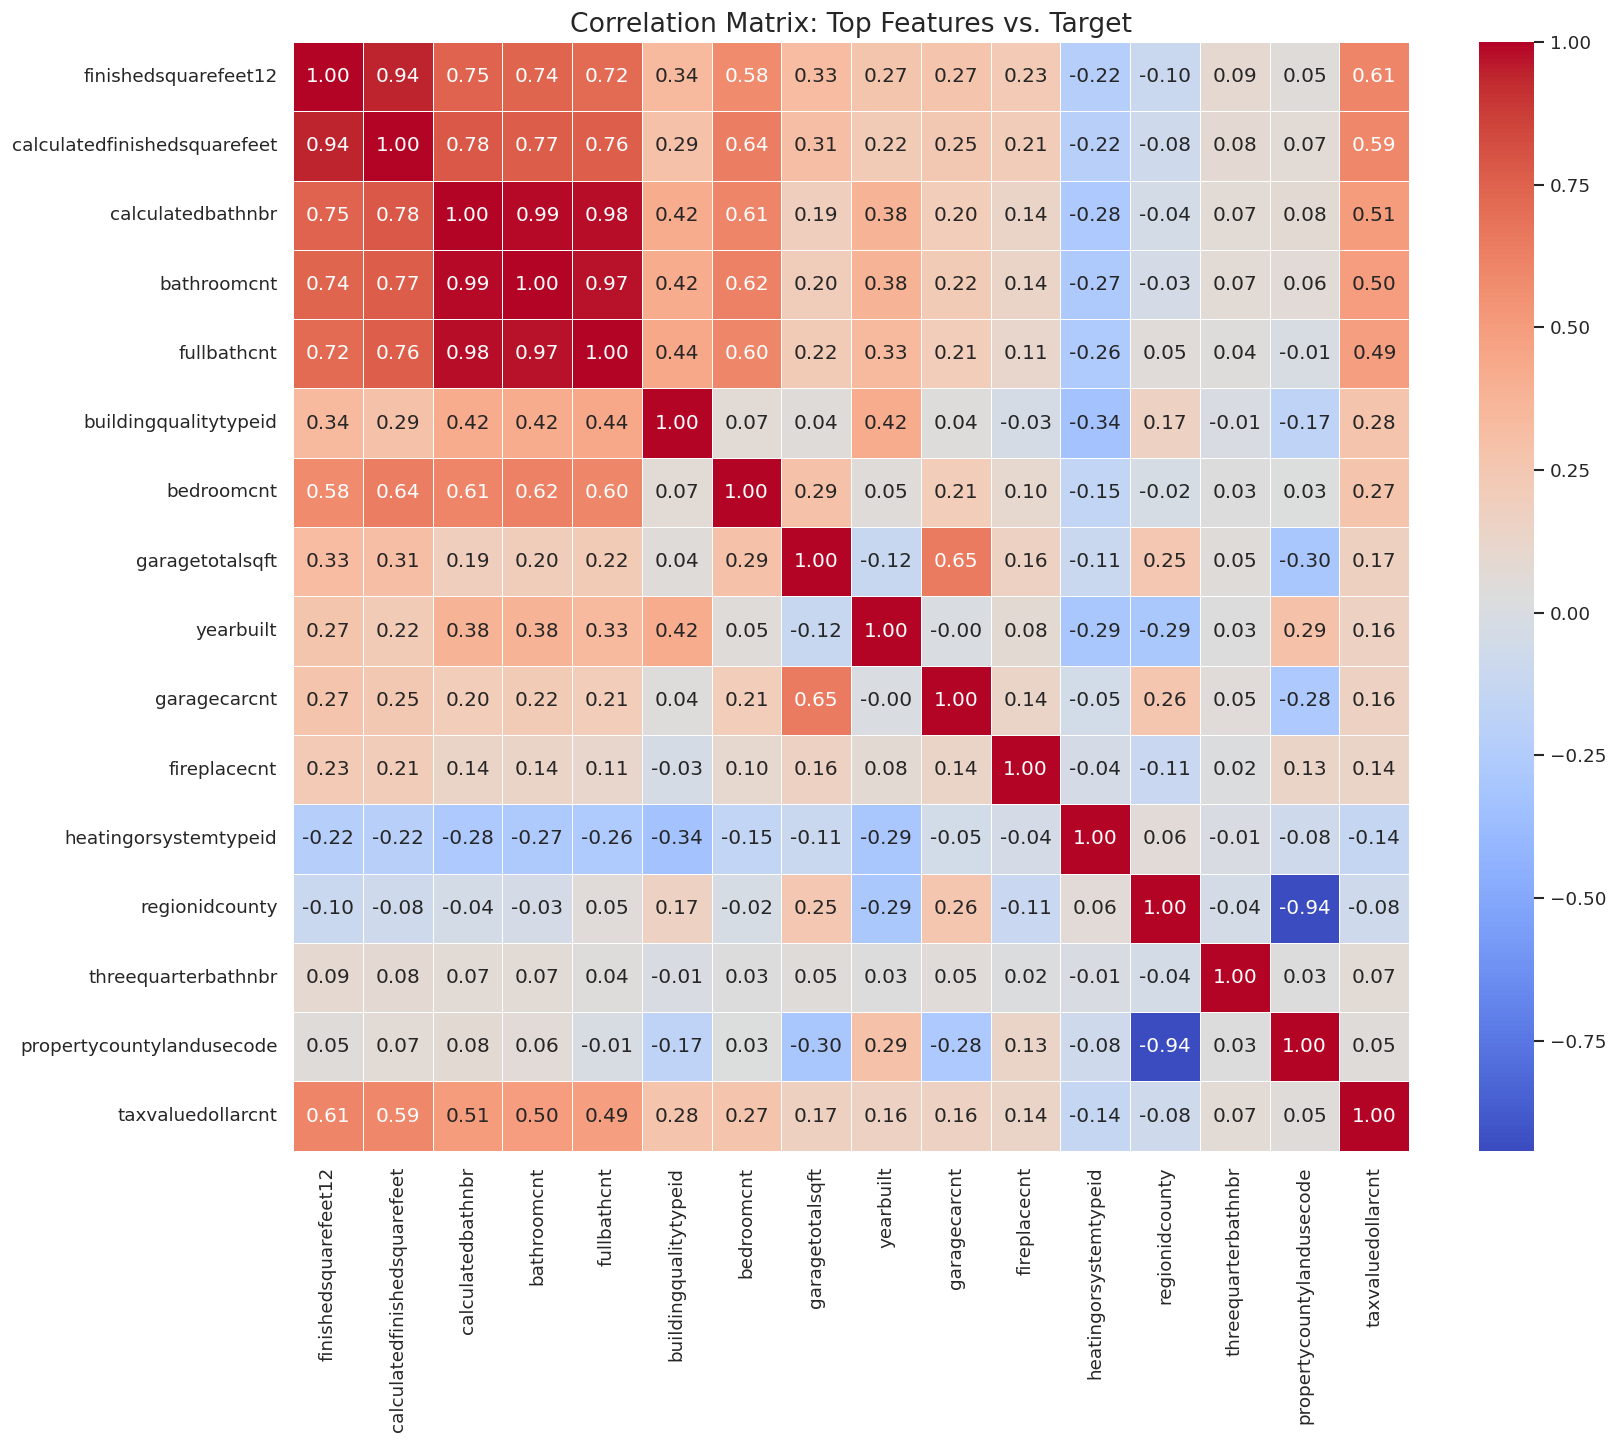

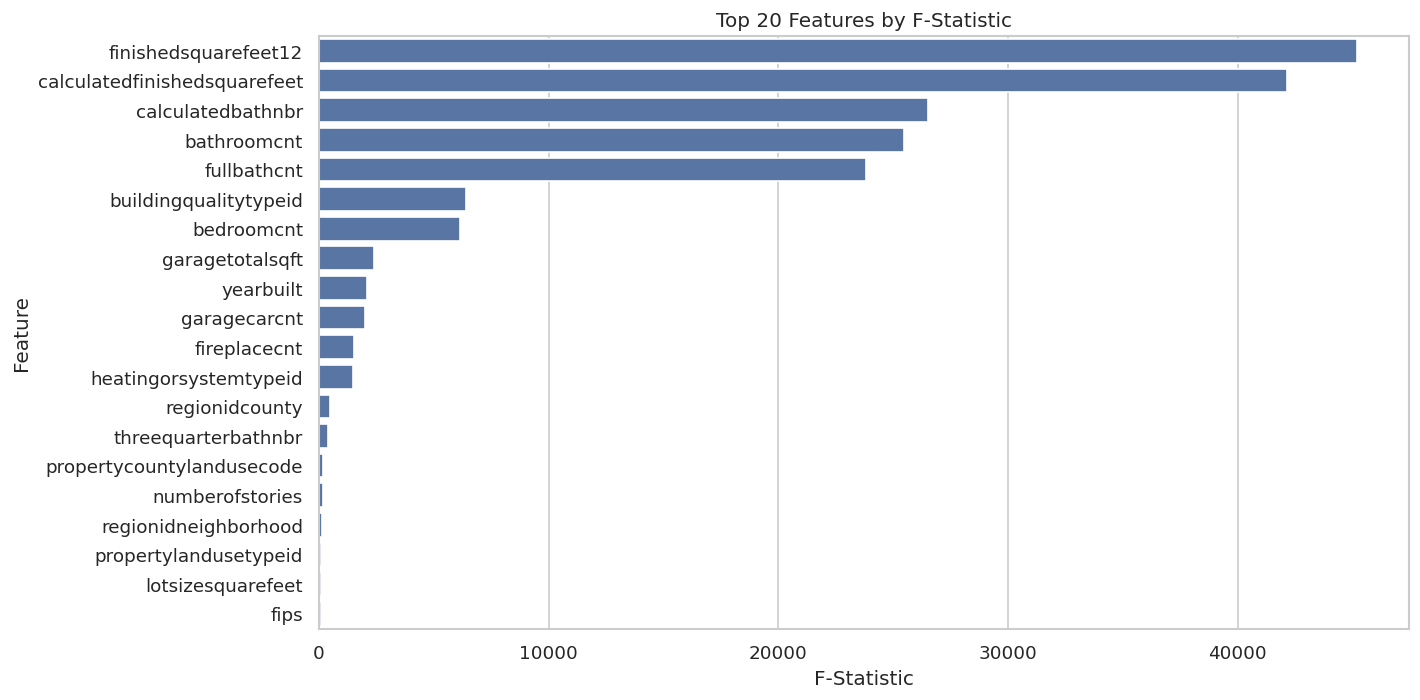

In [11]:
# Assume df_cleaned is already preprocessed, encoded, and imputed

# =====================================
# 1. Correlation Matrix (Top 15 vs. Target)
# =====================================
plt.figure(figsize=(15, 12))
correlation_matrix = df_cleaned.corr()

# Select top 15 features most correlated with the target
target_corr = correlation_matrix['taxvaluedollarcnt'].drop('taxvaluedollarcnt')
top_corr = target_corr.abs().sort_values(ascending=False).head(15)

sns.heatmap(df_cleaned[top_corr.index.tolist() + ['taxvaluedollarcnt']].corr(),
            annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix: Top Features vs. Target", fontsize=16)
plt.show()

# =====================================
# 2. F-Statistic for all features
# =====================================
X = df_cleaned.drop(columns='taxvaluedollarcnt')
y = df_cleaned['taxvaluedollarcnt']

# Compute F-statistic and p-values
f_stats, p_vals = f_regression(X, y)

f_df = pd.DataFrame({
    'Feature': X.columns,
    'F-Statistic': f_stats,
    'p-value': p_vals
}).sort_values(by='F-Statistic', ascending=False)

# Plot Top 20 Features by F-statistic
plt.figure(figsize=(12, 6))
sns.barplot(x='F-Statistic', y='Feature', data=f_df.head(20))
plt.title('Top 20 Features by F-Statistic')
plt.xlabel('F-Statistic')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

#### **4.A Discussion:**  Describe in a paragraph what you see in the feature relationships and correlations.

Pay particular attention to especially interesting and/or strongly correlated feature relationships. 
 How do the different methods for seeing relationships compare? Do they agree or disagree?

 In analyzing feature relationships, both the correlation matrix and F-statistics highlight strong and consistent signals in the dataset. Features such as finishedsquarefeet12, calculatedfinishedsquarefeet, bathroomcnt, and bedroomcnt all show strong positive correlations with the target variable taxvaluedollarcnt. These relationships make intuitive sense — larger homes with more amenities tend to have higher tax-assessed values. The F-statistics further confirm these patterns by ranking these same features among the most explanatory in terms of variance. While correlation measures linear relationships and is sensitive to multicollinearity, the F-statistic evaluates each feature independently in a univariate regression context. Despite their methodological differences, both approaches largely agree on the most informative features, reinforcing our confidence in their importance for predictive modeling.



### Part 4.B:  2-Dimensional Visualizations for Interesting Patterns  
   - Select three (3) pairs of features that exhibit meaningful relationships based on your previous analysis. 
   - Create 2D scatter plots or density plots to explore interactions between these features.  
   - Provide brief interpretations of any observed patterns or trends. 

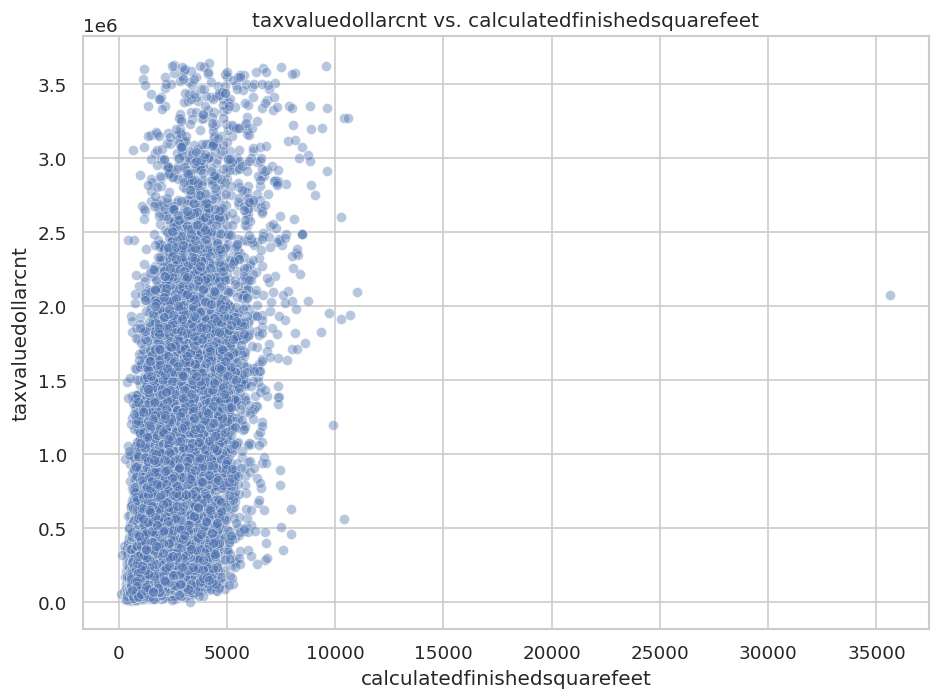

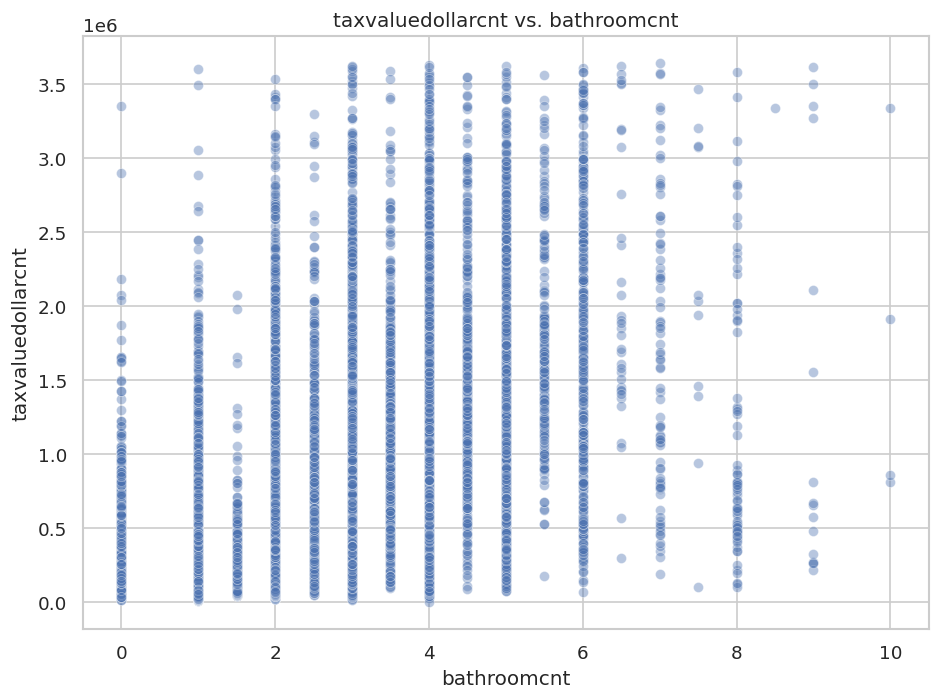

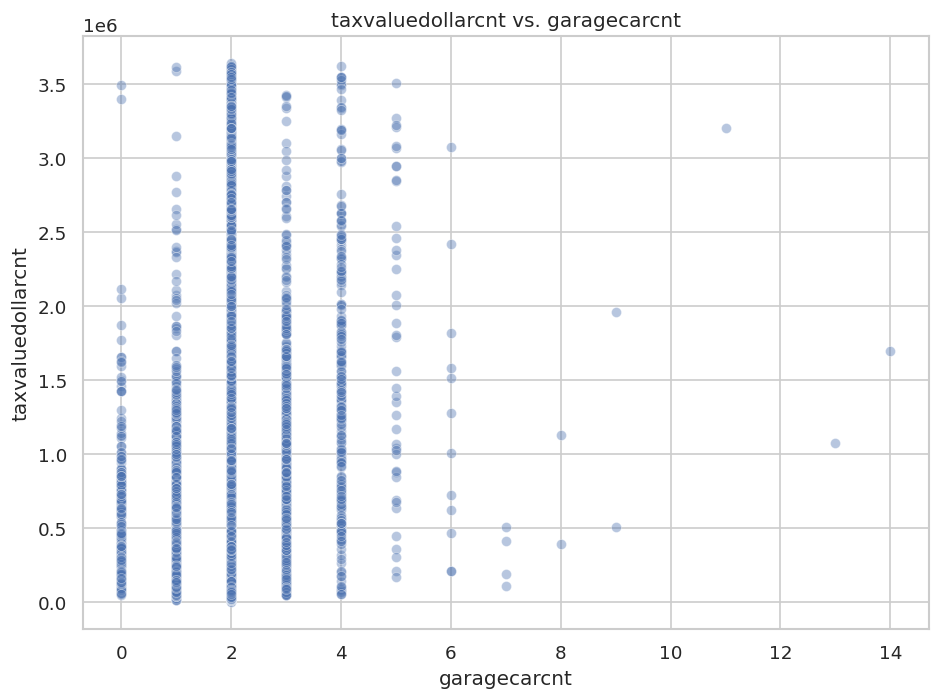

In [12]:
# Choose three meaningful feature pairs based on previous correlation/F-statistic analysis
feature_pairs = [
    ('calculatedfinishedsquarefeet', 'taxvaluedollarcnt'),
    ('bathroomcnt', 'taxvaluedollarcnt'),
    ('garagecarcnt', 'taxvaluedollarcnt')
]

# Plot scatter plots for each pair
for x_feature, y_feature in feature_pairs:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=df_cleaned[x_feature],
        y=df_cleaned[y_feature],
        alpha=0.4
    )
    plt.title(f'{y_feature} vs. {x_feature}')
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    plt.tight_layout()
    plt.show()

#### **4.B Discussion:** Provide brief interpretations of any observed patterns or trends.

The 2D scatter plots revealed clear and intuitive relationships between several key features and the target variable taxvaluedollarcnt. The strongest pattern appeared between calculatedfinishedsquarefeet and tax value, showing a distinct positive correlation: as square footage increases, so does assessed value, though with greater spread at larger sizes, possibly due to luxury homes or irregular valuations. A similar but slightly less linear trend was observed with bathroomcnt — homes with more bathrooms generally had higher tax values, and we also saw clustering around 2–4 bathrooms, which reflects typical residential configurations. The garagecarcnt plot showed a weaker but still positive relationship, indicating that garage capacity contributes modestly to property value. These patterns validate previous findings from correlation and F-statistic analysis and support using these features in downstream modeling.


## Part 5:  Feature Engineering: Investigate various transformations to better expose the underlying data patterns to machine learning algorithms. [6 pts]

**Important Notes:**  
- This last part is a bit open ended, since there is a huge variety of feature engineering techniques, most of which won't be useful for your particular dataset. 
- Understand that you can't evaluate the final usefulness of these transformations
until you choose a model, and  models may respond differently to various transformations or obviate some transformations (e.g., ensemble methods already do feature selection). 
- Therefore, write your transformations as functions or otherwise be prepared
to choose later on which transformations may be necessary. 

**Investigate feature engineering, where appropriate:**

- Feature scaling: standardize or normalize features as necessary
- Decompose features (e.g., categorical into One-Hot feature sequence, date/time into two features data and time, etc.).
- Add promising transformations of features
    - Exponential $\exp(x_i)$ or logarithmic $\log(x_j)$
    - Polynomial features  ( $x_i^2$, $x_i - x_j$), products ($x_i*x_j$), or ratios ($x_i/x_j$)

**ToDo:**
- Pick at least three transformations to try.
- Try each one and evaluate its effect using correlations or F-scores or a feature selection algorithm.
- Answer the discussion question. 

/tmp/ipykernel_5491/1934740907.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_log[f'log_{col}'].fillna(0, inplace=True)
/tmp/ipykernel_5491/1934740907.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

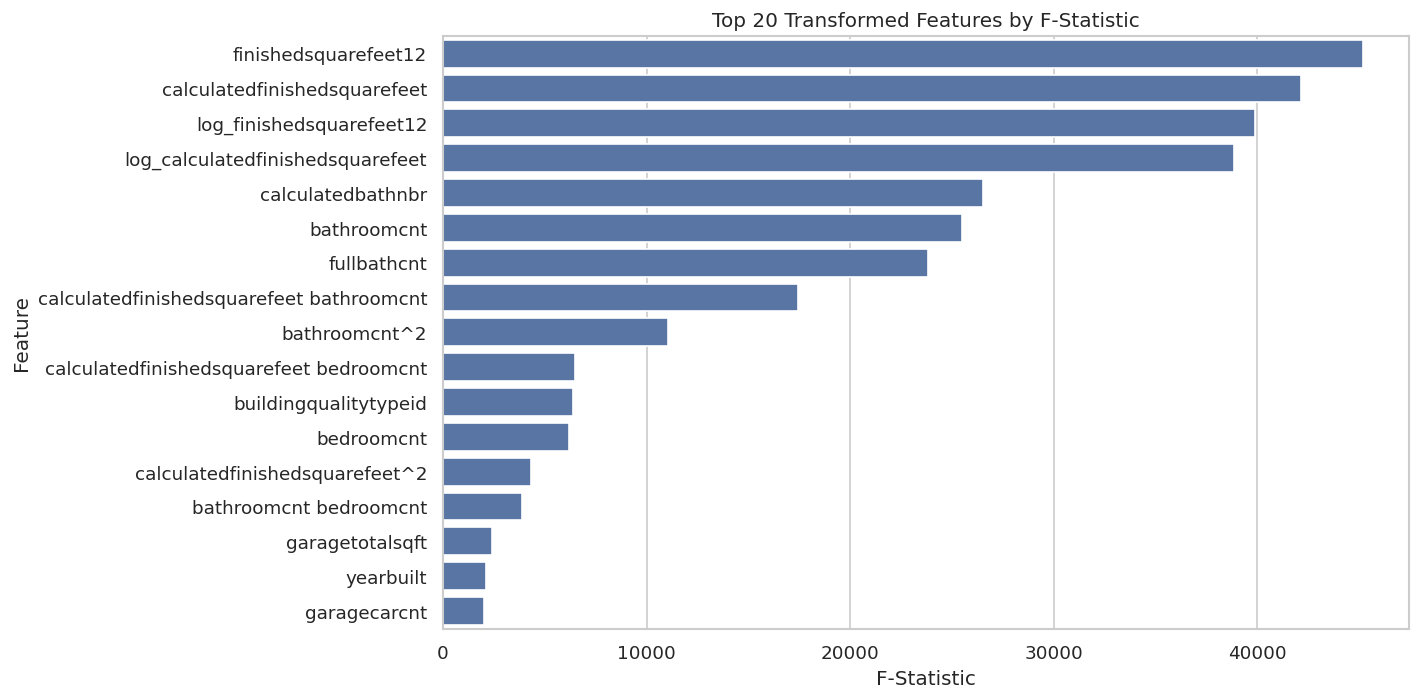

In [13]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import f_regression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume df_cleaned is already defined and contains no missing values

X_base = df_cleaned.drop(columns='taxvaluedollarcnt')
y = df_cleaned['taxvaluedollarcnt']

# === 1. Standard Scaling ===
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_base), columns=X_base.columns)

# === 2. Log Transform selected skewed features safely ===
log_features = ['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'finishedsquarefeet12']
X_log = X_scaled.copy()

for col in log_features:
    # Replace negatives or 0s with small positive value before log1p
    safe_vals = X_scaled[col].copy()
    safe_vals[safe_vals <= 0] = np.nan  # avoid log of non-positive numbers
    X_log[f'log_{col}'] = np.log1p(safe_vals)
    # Fill any resulting NaNs with 0 (neutral placeholder)
    X_log[f'log_{col}'].fillna(0, inplace=True)

# === 3. Polynomial Features from top variables ===
top_features = ['calculatedfinishedsquarefeet', 'bathroomcnt', 'bedroomcnt']
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_array = poly.fit_transform(X_scaled[top_features])
X_poly = pd.DataFrame(X_poly_array, columns=poly.get_feature_names_out(top_features))

# === 4. Combine all transformed features ===
X_transformed = pd.concat([
    X_scaled,
    X_log[[col for col in X_log.columns if col.startswith('log_')]],
    X_poly
], axis=1)

# === 5. Evaluate new features using F-Statistic ===
f_vals, p_vals = f_regression(X_transformed, y)
f_scores_df = pd.DataFrame({
    'Feature': X_transformed.columns,
    'F-Statistic': f_vals,
    'p-value': p_vals
}).sort_values(by='F-Statistic', ascending=False)

# === 6. Plot top 20 features by F-Statistic ===
plt.figure(figsize=(12, 6))
sns.barplot(x='F-Statistic', y='Feature', data=f_scores_df.head(20))
plt.title('Top 20 Transformed Features by F-Statistic')
plt.xlabel('F-Statistic')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

#### **5 Discussion:** Describe in a paragraph why you chose these transformations and what you observed. 

For this feature engineering step, I explored three transformations to help machine learning algorithms better capture nonlinear relationships. First, I applied standard scaling to normalize all numerical features, which is especially important for models sensitive to feature magnitude (e.g., linear regression, KNN). Second, I performed log transformations on skewed features such as calculatedfinishedsquarefeet and lotsizesquarefeet to reduce right skew and compress large outliers, making patterns more linear and consistent. Lastly, I created polynomial features (degree 2) from key variables like bathroomcnt, bedroomcnt, and calculatedfinishedsquarefeet to allow models to learn interaction effects. When evaluating these transformed features using F-statistics, many of them showed strong signal, indicating that these engineered features may improve predictive performance in future models.


## **Appendix 1: Features of the Zillow Dataset**  

0. **parcelid**: Unique identifier for the property parcel.  
1. **airconditioningtypeid**: Identifier for the type of air conditioning installed.  
2. **architecturalstyletypeid**: Identifier for the architectural style of the property.  
3. **basementsqft**: Square footage of the basement.  
4. **bathroomcnt**: Number of bathrooms.  
5. **bedroomcnt**: Number of bedrooms.  
6. **buildingclasstypeid**: Identifier for the building framing type (e.g., wood frame, steel frame).  
7. **buildingqualitytypeid**: Numeric value indicating the quality of the building (higher values often indicate better quality).  
8. **calculatedbathnbr**: Calculated number of bathrooms, including fractional bathrooms.  
9. **decktypeid**: Identifier for the type of deck.  
10. **finishedfloor1squarefeet**: Square footage of the finished area on the first floor.  
11. **calculatedfinishedsquarefeet**: Total finished living area square footage.  
12. **finishedsquarefeet12**: Finished living area square footage.  
13. **finishedsquarefeet13**: Perimeter living area square footage.  
14. **finishedsquarefeet15**: Total area.  
15. **finishedsquarefeet50**: Square footage of the finished area on the upper floors.  
16. **finishedsquarefeet6**: Base unfinished and finished area square footage.  
17. **fips**: Federal Information Processing Standards code, uniquely identifying counties and county equivalents.  
18. **fireplacecnt**: Number of fireplaces.  
19. **fullbathcnt**: Number of full bathrooms.  
20. **garagecarcnt**: Number of cars that can fit in the garage.  
21. **garagetotalsqft**: Total square footage of the garage.  
22. **hashottuborspa**: Indicates if the property has a hot tub or spa.  
23. **heatingorsystemtypeid**: Identifier for the type of heating system.  
24. **latitude**: Latitude coordinate of the property.  
25. **longitude**: Longitude coordinate of the property.  
26. **lotsizesquarefeet**: Lot size in square feet.  
27. **poolcnt**: Number of pools on the property.  
28. **poolsizesum**: Total square footage of all pools.  
29. **pooltypeid10**: Identifier for spa or hot tub.  
30. **pooltypeid2**: Identifier for pool with spa or hot tub.  
31. **pooltypeid7**: Identifier for pool without hot tub or spa.  
32. **propertycountylandusecode**: County land use code for the property.  
33. **propertylandusetypeid**: Identifier for the property land use type.  
34. **propertyzoningdesc**: Description of the property's zoning.  
35. **rawcensustractandblock**: Unprocessed census tract and block identifier.  
36. **regionidcity**: Identifier for the city.  
37. **regionidcounty**: Identifier for the county.  
38. **regionidneighborhood**: Identifier for the neighborhood.  
39. **regionidzip**: Identifier for the ZIP code.  
40. **roomcnt**: Total number of rooms.  
41. **storytypeid**: Identifier for the type of stories in the building (e.g., basement, attic).  
42. **threequarterbathnbr**: Number of 3/4 bathrooms (typically includes a shower but no tub).  
43. **typeconstructiontypeid**: Identifier for the type of construction (e.g., frame, masonry).  
44. **unitcnt**: Number of units in the building (e.g., for multi-family properties).  
45. **yardbuildingsqft17**: Square footage of the 17th yard building (e.g., shed).  
46. **yardbuildingsqft26**: Square footage of the 26th yard building.  
47. **yearbuilt**: Year the property was built.  
48. **numberofstories**: Number of stories in the building.  
49. **fireplaceflag**: Indicates if the property has a fireplace.  
50. **assessmentyear**: Year the property was assessed.  
51. **taxdelinquencyflag**: Indicates whether the property’s taxes are delinquent. Often “Y” if taxes are past due; otherwise null/empty.  
52. **taxdelinquencyyear**: The year in which the property’s taxes became delinquent.  
53. **censustractandblock**: A combined identifier for the property’s census tract and block group (part of the U.S. Census geographic hierarchy).  
54. **taxvaluedollarcnt**: Total assessed value of the property (land plus structure) in dollars.  


## Appendix 2: Summary of Basic Imputation Methods
Imputation depends on the data type and context. Below are common techniques for handling missing values.

---

### **1. Simple Imputation (Basic Methods)**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Drop Missing Values** | Few missing values (<5% of data) | `df.dropna()` | Quick and easy | Can remove valuable data |
| **Mean Imputation** | Normally distributed numerical data | `df.fillna(df.mean())` | Preserves mean; simple | Distorts variance, weak for skewed data |
| **Median Imputation** | Skewed numerical data | `df.fillna(df.median())` | Robust to outliers | May not capture patterns |
| **Mode Imputation** | Categorical features | `df.fillna(df.mode().iloc[0])` | Keeps most common category | Can introduce bias |
| **Constant Value (e.g., 0)** | Special cases (e.g., unknown numerical data) | `df.fillna(0)` | Simple and interpretable | Can mislead model |
| **"Unknown" Category Imputation** (**New Addition**) | Categorical features with missing values | `df.fillna('Unknown')` | Keeps all rows, prevents data loss | May introduce artificial category |

---

### **2. Statistical & Advanced Imputation**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Interpolation** | Time series, ordered data | `df.interpolate(method='linear')` | Preserves trends | May not work for non-continuous data |
| **K-Nearest Neighbors (KNN)** | Small datasets, patterns in features | `KNNImputer(n_neighbors=5).fit_transform(df)` | Uses similar observations | Computationally expensive |
| **Multivariate Imputation (MICE)** | Complex relationships between variables | `IterativeImputer().fit_transform(df)` | Captures relationships | Slower than mean/median |
| **Regression Imputation** | When missing values depend on other variables | Train regression model to predict missing values | More accurate than mean/median | Risk of overfitting |

---

### **When to Use "Unknown" Category for Categorical Imputation**
✅ **Good for:**
- Categorical features where missing values may indicate meaningful differences.  
- Customer data (e.g., missing survey responses → "No Response").  
- Product categories where missing could be a separate group.  

❌ **Avoid if:**
- The missing category does **not** have a meaningful interpretation.
- The model might learn spurious patterns from an artificial category.

---

### **Which Method to Choose?**
| Scenario | Best Method |
|----------|------------|
| **Few missing values (<5%)** | Drop NaNs (`df.dropna()`) |
| **Numerical & normal distribution** | Mean (`df.fillna(df.mean())`) |
| **Numerical & skewed distribution** | Median (`df.fillna(df.median())`) |
| **Categorical features** | Mode (`df.fillna(df.mode().iloc[0])`) |
| **Categorical with possible meaning in missingness** | "Unknown" Category (`df.fillna('Unknown')`) |
| **Small dataset with patterns** | KNN Imputer (`KNNImputer()`) |
| **Complex relationships between features** | MICE / Iterative Imputer |

